In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import itertools

In [8]:
def plot_confusion_matrix(cm, classes, title):
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.grid(False)

### Loading in the data with the desired features

In [24]:
cols = ['gender', 'birthyr', 'educ', 'race', 'countyfips', 'pew_religimp', 'newsint', 'CC16_351I', 'CC16_302', 'CC16_331_7', 'CC16_330d', 'CC16_332a', 'CC16_351K', 'CC16_335', 'CC16_364c']
df = pd.read_csv('data/CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t', header=0, usecols=cols)[cols]
df = df[(df.CC16_364c == 1.0) | (df.CC16_364c == 2.0)] # getting only the people who preferred Trump, Clinton, or weren't sure
df = df.dropna().astype(int).rename(columns={'birthyr': 'age', 'countyfips': 'state'})
df.age = 2016 - df.age
df['state'] = df['state'].map(lambda x: f'{x:05}'[:2]) # converting county fips to state ID string

In [30]:
df

,gender,age,educ,race,state,pew_religimp,newsint,CC16_351I,CC16_302,CC16_331_7,CC16_330d,CC16_332a,CC16_351K,CC16_335,CC16_364c
0,2,47,2,1,33,2,2,1,3,1,2,1,1,1,1
2,2,52,2,2,29,1,2,1,5,2,1,2,1,1,2
4,2,34,5,1,08,4,1,2,2,2,1,2,1,1,2
5,2,53,2,6,01,1,3,1,4,1,1,1,1,1,2
6,1,54,2,1,48,1,1,1,3,1,2,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64593,1,30,2,1,17,3,1,1,4,2,1,1,1,2,1
64594,1,49,2,1,32,2,1,1,2,1,1,1,1,1,1
64595,1,26,3,2,36,1,1,2,1,2,1,1,1,1,1
64597,1,38,2,1,22,2,1,2,2,2,2,1,1,1,2


### Verifying that there are no "skipped" responses, crosschecked to the data source

In [35]:
features = df.columns.tolist()
features.remove('age')
features.remove('state')
for feature in features:
    print(f'{feature} : {df[feature].unique()}')

gender : [2 1]
educ : [2 5 3 6 4 1]
race : [1 2 6 4 3 5 7 8]
pew_religimp : [2 1 4 3]
newsint : [2 1 3 7 4]
CC16_351I : [1 2]
CC16_302 : [3 5 2 4 6 1]
CC16_331_7 : [1 2]
CC16_330d : [2 1]
CC16_332a : [1 2]
CC16_351K : [1 2]
CC16_335 : [1 2]
CC16_364c : [1 2]


### Verifying that there are no highly correlated features

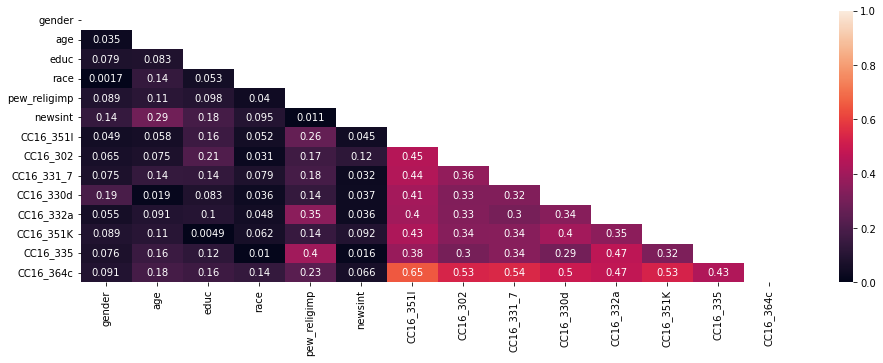

In [38]:
plt.figure(figsize=(16, 5))
corr = df.corr().abs()
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
corr = corr.where(cond=mask)
sns.heatmap(corr, annot=True, vmin=0, vmax=1);

### splitting the data

In [47]:
def sampling_k_elements(group, k=min(df.CC16_364c.value_counts())):
    if len(group) < k:
        return group
    return group.sample(k)

df = df.groupby('CC16_364c').apply(sampling_k_elements).reset_index(drop=True)

In [55]:
train, test = train_test_split(df, stratify=df.CC16_364c, test_size=0.3, random_state=42)
data_train, data_eval, label_train, label_eval = train_test_split(train.drop('CC16_364c', axis=1), train.CC16_364c, stratify=train.CC16_364c, test_size=0.3, random_state=42)
data_test, label_test = test.drop('CC16_364c', axis=1), test.CC16_364c

In [56]:
label_train.value_counts()

2    9194
1    9193
Name: CC16_364c, dtype: int64

In [57]:
label_eval.value_counts()

1    3941
2    3940
Name: CC16_364c, dtype: int64

In [58]:
label_test.value_counts()

1    5629
2    5629
Name: CC16_364c, dtype: int64

### making the model

In [59]:
categorical_features_indices = np.where(train.dtypes != int)[0]

In [97]:
classifier = CatBoostClassifier(iterations=1000, depth=3, learning_rate=0.05, loss_function='Logloss', eval_metric='Accuracy')
classifier.fit(data_train, label_train, cat_features=categorical_features_indices, eval_set=(data_eval, label_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8610431	test: 0.8556021	best: 0.8556021 (0)	total: 40.1ms	remaining: 40.1s
1:	learn: 0.8749660	test: 0.8733663	best: 0.8733663 (1)	total: 71.8ms	remaining: 35.8s
2:	learn: 0.8737695	test: 0.8703210	best: 0.8733663 (1)	total: 99.1ms	remaining: 32.9s
3:	learn: 0.8623484	test: 0.8563634	best: 0.8733663 (1)	total: 141ms	remaining: 35s
4:	learn: 0.8608800	test: 0.8559827	best: 0.8733663 (1)	total: 158ms	remaining: 31.4s
5:	learn: 0.8700712	test: 0.8677833	best: 0.8733663 (1)	total: 175ms	remaining: 29s
6:	learn: 0.8700712	test: 0.8677833	best: 0.8733663 (1)	total: 193ms	remaining: 27.3s
7:	learn: 0.8677326	test: 0.8666413	best: 0.8733663 (1)	total: 209ms	remaining: 25.9s
8:	learn: 0.8677326	test: 0.8666413	best: 0.8733663 (1)	total: 227ms	remaining: 25s
9:	learn: 0.8688204	test: 0.8668951	best: 0.8733663 (1)	total: 249ms	remaining: 24.6s
10:	learn: 0.8688204	test: 0.8668951	best: 0.8733663 (1)	total: 278ms	remaining: 25s
11:	learn: 0.8756730	test: 0.8718437	best: 0.8733663 (1)	t

In [98]:
preds = classifier.predict(data_test)

In [99]:
from sklearn.metrics import f1_score

In [100]:
classifier.score(data_test, label_test)

0.9066441641499379

In [101]:
print('F1 score: ', f1_score(label_test, preds, average='weighted'))

F1 score:  0.9066417709453456


### classifier cm

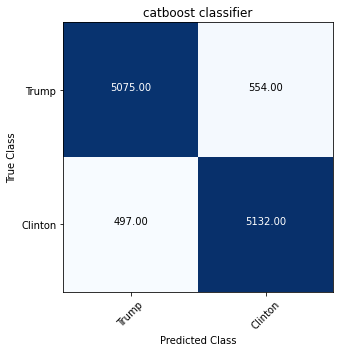

In [102]:
cm = confusion_matrix(label_test, preds, labels=[1, 2])
plot_confusion_matrix(cm, ['Trump', 'Clinton'], 'catboost classifier')

In [143]:
classifier.save_model("catboost_classifier")

In [104]:
# Get predicted classes
preds_class = classifier.predict(data_test)

# Get predicted probabilities for each class
preds_proba = classifier.predict_proba(data_test)

# Get predicted RawFormulaVal
preds_raw = classifier.predict(data_test, 
                          prediction_type='RawFormulaVal')

In [108]:
classifier.classes_

array([1, 2], dtype=int64)

In [105]:
preds_class

array([1, 1, 2, ..., 1, 1, 1], dtype=int64)

In [106]:
preds_proba

array([[0.96725094, 0.03274906],
       [0.97501512, 0.02498488],
       [0.00836101, 0.99163899],
       ...,
       [0.99496169, 0.00503831],
       [0.9339546 , 0.0660454 ],
       [0.96828566, 0.03171434]])

In [107]:
preds_raw

array([-3.38558382, -3.66418197,  4.77577989, ..., -5.28563295,
       -2.64908548, -3.41875836])

In [116]:
mask = label_test != preds_class

In [117]:
label_test[mask]

18560    1
13509    1
34455    2
11069    1
27573    2
        ..
29333    2
12225    1
17219    1
13472    1
20426    2
Name: CC16_364c, Length: 1051, dtype: int32

In [118]:
preds_class[mask]

array([2, 2, 1, ..., 2, 2, 1], dtype=int64)

In [120]:
preds_proba[mask]

array([[0.38908748, 0.61091252],
       [0.37821883, 0.62178117],
       [0.93808203, 0.06191797],
       ...,
       [0.22940558, 0.77059442],
       [0.27649278, 0.72350722],
       [0.75366162, 0.24633838]])

In [123]:
preds_raw.max()

6.611698987761777

In [124]:
preds_raw.min()

-7.363727707711516

In [125]:
playing = preds_proba

In [138]:
mask = playing[:,0] < 0.5
# np.where(mask, -playing[:,1], playing[:,0])
(np.where(mask, -playing[:,1], playing[:,0]) + 1) / 2

array([0.98362547, 0.98750756, 0.0041805 , ..., 0.99748084, 0.9669773 ,
       0.98414283])

(array([2139.,  823.,  456.,  306.,  231.,  188.,  156.,  134.,  122.,
         107.,   94.,   86.,   80.,   83.,   77.,   70.,   48.,   59.,
          56.,   50.,   71.,   68.,   65.,   60.,   57.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   57.,   53.,   53.,   47.,   50.,   57.,
          65.,   59.,   58.,   68.,   70.,   75.,   83.,   88.,   90.,
          80.,  116.,  116.,  132.,  167.,  222.,  280.,  374.,  670.,
        2442.]),
 array([6.71370232e-04, 1.06614894e-02, 2.06516085e-02, 3.06417277e-02,
        4.06318468e-02, 5.06219660e-02, 6.06120851e-02, 7.06022043e-02,
        8.05923234e-02, 9.05824426e-02, 1.00572562e-01, 1.

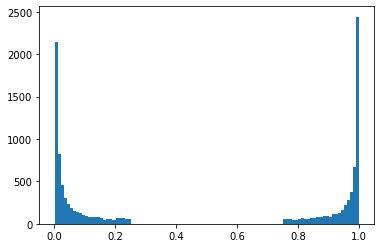

In [141]:
plt.hist((np.where(mask, -playing[:,1], playing[:,0]) + 1) / 2, bins=100)